## Informacje o procesorze

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 12 16:03:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Instalacja i wersje pakietów

In [3]:
pip install colorama

In [4]:
import torch
import time
import torchvision
import pandas as pd
import numpy as np
import matplotlib as plt
import sklearn
from colorama import Fore

In [5]:
!python --version
print('Torch: ', torch.__version__)
print('Torchvision: ', torchvision.__version__)
print('Pandas: ', pd.__version__)
print('Numpy: ', np.__version__)
print('Sklearn: ', sklearn.__version__)
print('Matplotlib: ', plt.__version__)

Python 3.10.12
Torch:  2.2.1+cu121
Torchvision:  0.17.1+cu121
Pandas:  2.0.3
Numpy:  1.25.2
Sklearn:  1.2.2
Matplotlib:  3.7.1


In [6]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

# Pobranie i przygotowanie zestawu danych


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Zmniana do wymaganych wymiarów dla AlexNet
    transforms.Grayscale(num_output_channels=3),  # Konwersja do 3 kanałów
    transforms.ToTensor(),
])

# Pobranie zbioru testowego i treningowego w stosunku 70/10
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Złączenie zbioru testowego i treningowego
combined_data = ConcatDataset([mnist_train, mnist_test])

100%|██████████| 9912422/9912422 [00:00<00:00, 178743384.54it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 24193268.19it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 85025527.69it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3503867.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
print(f'Ilość danych ogółem: ', len(combined_data))

print(f'{Fore.GREEN}Obrazy zostały załadowane pomyślnie!{Fore.BLACK}')

Ilość danych ogółem:  70000
Obrazy zostały załadowane pomyślnie!


# Funkcje niestandardowe

___

In [9]:
import random

# Ustawienie ziarna losowości dla powtarzalności wyników
def set_seed(seed_value: int = 42):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

In [10]:
from torch.utils.data import random_split

def split_dataset(dataset):
  # Obliczanuie długości dla zbioru testowego i treningowego w stosunku 80/20
  train_size = int(0.8 * len(dataset))
  validation_size = len(dataset) - train_size

  # Podzielenie na dwa zestawy danych
  train_ds, validation_ds = random_split(dataset, [train_size, validation_size])
  return train_ds, validation_ds

In [11]:
import pandas as pd

INDEXES = ["Czas treningu", "Dokładność treningowa", "Dokładność walidacyjna", "Strata treningowa", "Strata walidacyjna"]

def create_df(output_data: dict) -> pd.DataFrame:
  return pd.DataFrame(output_data, index=INDEXES)

## AlexNet model

In [78]:
from torchvision.models import alexnet
import torch.nn as nn
import torch.optim as optim

def create_alexnet_model():
    model = alexnet(weights=True)
    # Dostosowanie do 10 klas dla zestawu MNIST
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from collections import defaultdict

def train_alexnet_on_mnist(model, criterion, optimizer, train_loader, val_loader, epochs=10, device=DEVICE) -> list:
    output_data_alexnet = defaultdict(list)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = running_loss / len(val_loader)
        test_accuracy = 100 * correct / total

        output_data_alexnet[epoch] = [train_accuracy, test_accuracy, train_loss, test_loss]
        print(f'Epoch {epoch+1}/{epochs} | loss: {train_loss:.2f}% - accuracy: {train_accuracy:.2f}%, val_loss: {test_loss:.2f}% - val_accuracy: {test_accuracy:.2f}%')

    return output_data_alexnet


In [24]:
def validate_model(model, test_loader, device = DEVICE):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(true_labels)

## Plotting

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Etykiety przewidziane przez model')
    plt.ylabel('Etykiety rzeczywiste')
    plt.title('Macierz Pomyłek')
    plt.show()

In [62]:
from sklearn.metrics import roc_curve, auc

def compute_auc_per_class(true_labels, predictions):
    if len(predictions.shape) > 1:
        num_classes = predictions.shape[1]
    else:
        num_classes = len(np.unique(true_labels))
    aucs = []
    for i in range(num_classes):
        if len(predictions.shape) > 1:
            fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
        else:
            true_labels_class = (true_labels == i).astype(int)
            fpr, tpr, _ = roc_curve(true_labels_class, predictions)
        auc_value = auc(fpr, tpr)
        aucs.append(auc_value)
    average_auc = np.mean(aucs)
    return aucs, average_auc

In [74]:
from sklearn.metrics import roc_curve, auc

def test_class_probabilities(model, device, test_loader, which_class):
    model.eval()
    actuals = []
    probabilities = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend((target.view_as(prediction) == which_class).cpu().numpy())
            probabilities.extend(torch.exp(output[:, which_class]).cpu().numpy())
    return actuals, probabilities

def plot_ROC(model, test_loader, which_class=2, device=DEVICE):
    actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

    fpr, tpr, _ = roc_curve(actuals, class_probabilities)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='Krzywa ROC (obszar = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Wartości False Positive')
    plt.ylabel('Wartości True Positive')
    plt.title(f'Krzywa ROC dla klasy {which_class}')
    plt.legend(loc="lower right")
    plt.show()

In [71]:
from sklearn.metrics import precision_recall_fscore_support

def compute_precision_recall_f1score(true_labels, predictions, num_classes):
    precision, recall, f1score, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    return precision, recall, f1score

In [26]:
import matplotlib.pyplot as plt

def plot_results(model_df: pd.DataFrame) -> None:
    # Transpozycja DataFrame dla łatwiejszego plotowania
    df_t = model_df.T

    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))

    # Plotowanie dokładności
    plt.plot(df_t.index, df_t["Dokładność treningowa"], '-o', label='Dokładność testowa', color='red')
    plt.plot(df_t.index, df_t["Dokładność walidacyjna"], '-o', label='Dokładność walidacyjna', color='orange')

    # Plotowanie straty
    plt.plot(df_t.index, df_t["Strata treningowa"], '-o', label='Strata testowa', color='blue')
    plt.plot(df_t.index, df_t["Strata walidacyjna"], '-o', label='Strata walidacyjna', color='green')

    # Dodanie tytułu i etykiet
    plt.title('Dokładność i strata w zależności od ilości danych wejściowych')
    plt.xlabel('Ilość danych wejściowych')
    plt.ylabel('Wartości [%]')

    # Dodanie legendy
    plt.legend()

    # Pokazanie wykresu
    plt.show()

In [25]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(data) -> None:
    """ Tworzenie wykresów dokładności i straty dla modelu

    Args:
        history (model): Wytrenowany model
    """
    # Wykresy dokładności i straty
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Wykres dokładności modelu
    axs[0].plot(data['accuracy'], label=f'Dokładność testowa')
    axs[0].plot(data['val_accuracy'], label='Dokładność walidacyjna')
    axs[0].set_title(f'Dokładność modelu')
    axs[0].set_ylabel('Dokładność [%]')
    axs[0].set_xlabel('Liczba epok')
    axs[0].legend(loc='lower right')
    axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

    # Wykres starty modelu
    axs[1].plot(data['loss'], label='Strata treningowa')
    axs[1].plot(data['val_loss'], label='Strata walidacyjna')
    axs[1].set_title(f'Strata modelu')
    axs[1].set_ylabel('Strata [%]')
    axs[1].set_xlabel('Liczba epok')
    axs[1].legend(loc='upper right')
    axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

    plt.tight_layout()
    plt.show()

# Badanie optymalnej ilości wolumenu danych

In [28]:
# Ustawienie ziarna dla reprodukowalności
np.random.seed(42)

# Generowanie losowej liczby całkowitej z przedziału od 0 do 100
seeds = [np.random.randint(0, 101) for i in range(0, 5)]
seeds

[51, 92, 14, 71, 60]


 ----------------------------------------   Model AlexNet/0  ---------------------------------------- 



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 ----------------------------------------  Trening modelu AlexNet/0  ---------------------------------------- 

Epoch 1/10 | loss: 0.52% - accuracy: 83.78%, val_loss: 0.11% - val_accuracy: 96.52%
Epoch 2/10 | loss: 0.14% - accuracy: 95.96%, val_loss: 0.08% - val_accuracy: 97.88%
Epoch 3/10 | loss: 0.11% - accuracy: 96.97%, val_loss: 0.06% - val_accuracy: 98.37%
Epoch 4/10 | loss: 0.09% - accuracy: 97.57%, val_loss: 0.07% - val_accuracy: 98.13%
Epoch 5/10 | loss: 0.09% - accuracy: 97.80%, val_loss: 0.06% - val_accuracy: 98.35%
Epoch 6/10 | loss: 0.08% - accuracy: 97.79%, val_loss: 0.07% - val_accuracy: 98.23%
Epoch 7/10 | loss: 0.06% - accuracy: 98.28%, val_loss: 0.05% - val_accuracy: 98.67%
Epoch 8/10 | loss: 0.07% - accuracy: 98.15%, val_loss: 0.09% - val_accuracy: 98.55%
Epoch 9/10 | loss: 0.06% - accuracy: 98.34%, val_loss: 0.05% - val_accuracy: 98.60%
Epoch 10/10 | loss: 0.06% - accuracy: 98.43%, val_loss: 0.08% - val_accuracy: 98.52%
Trening ukończony w: 553.6893289089203 sekund


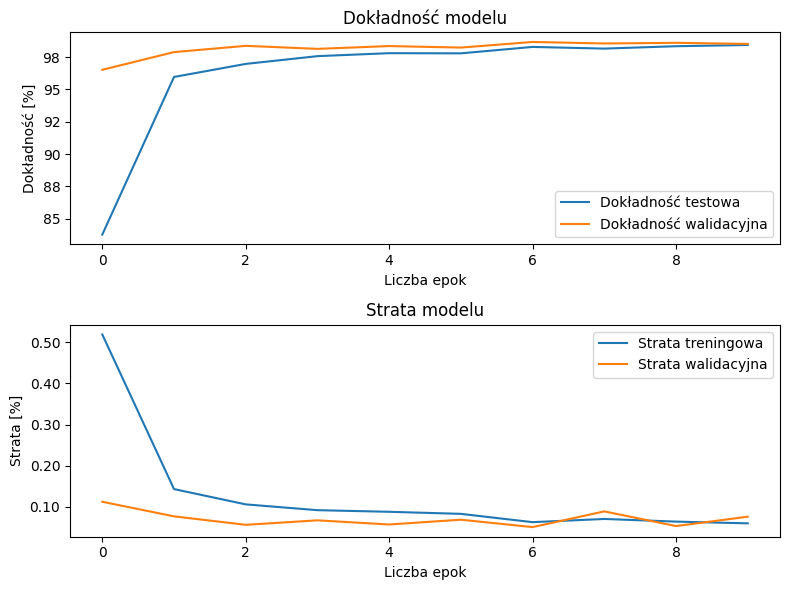


 ----------------------------------------  Testowanie modelu VGG16/0  ---------------------------------------- 


 ----------------------------------------  Macierz pomyłek VGG16/0  ---------------------------------------- 



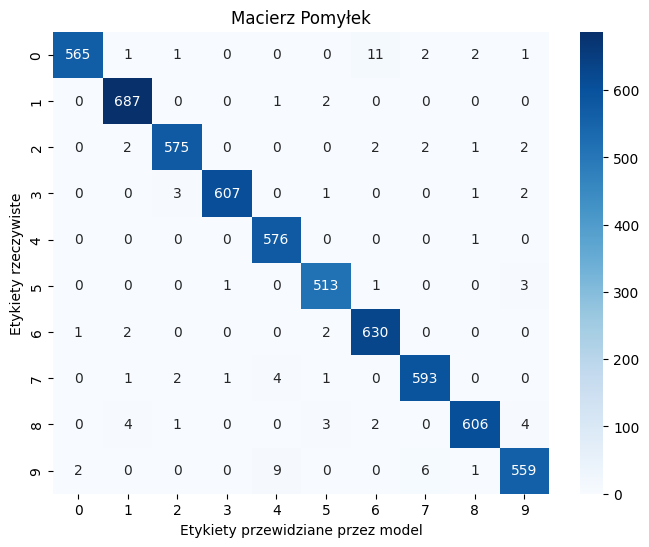


 ----------------------------------------  AUC i ROC VGG16/0  ---------------------------------------- 



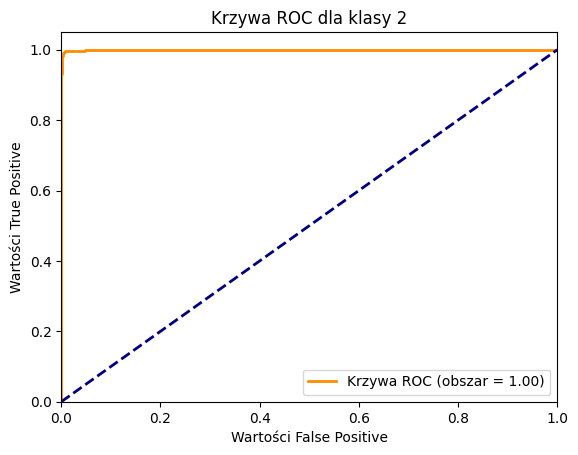

AUC dla klasy 0: 0.019
AUC dla klasy 1: 0.109
AUC dla klasy 2: 0.24
AUC dla klasy 3: 0.345
AUC dla klasy 4: 0.455
AUC dla klasy 5: 0.558
AUC dla klasy 6: 0.663
AUC dla klasy 7: 0.775
AUC dla klasy 8: 0.887
AUC dla klasy 9: 0.986

Average AUC: 0.5038


 ----------------------------------------  Metryki pomiarowe VGG16/9  ---------------------------------------- 

Precision: 0.9851918117860803
Recall: 0.9849979498468955
F1-Score: 0.9850458911605919

 ----------------------------------------   Model AlexNet/1  ---------------------------------------- 



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 ----------------------------------------  Trening modelu AlexNet/1  ---------------------------------------- 

Epoch 1/10 | loss: 0.32% - accuracy: 90.03%, val_loss: 0.08% - val_accuracy: 97.93%
Epoch 2/10 | loss: 0.11% - accuracy: 97.03%, val_loss: 0.06% - val_accuracy: 98.55%
Epoch 3/10 | loss: 0.10% - accuracy: 97.36%, val_loss: 0.08% - val_accuracy: 98.05%
Epoch 4/10 | loss: 0.09% - accuracy: 97.89%, val_loss: 0.07% - val_accuracy: 98.38%
Epoch 5/10 | loss: 0.07% - accuracy: 98.27%, val_loss: 0.08% - val_accuracy: 97.68%
Epoch 6/10 | loss: 0.08% - accuracy: 97.83%, val_loss: 0.06% - val_accuracy: 98.40%
Epoch 7/10 | loss: 0.06% - accuracy: 98.52%, val_loss: 0.05% - val_accuracy: 98.82%
Epoch 8/10 | loss: 0.06% - accuracy: 98.67%, val_loss: 0.09% - val_accuracy: 98.50%
Epoch 9/10 | loss: 0.06% - accuracy: 98.60%, val_loss: 0.07% - val_accuracy: 98.43%
Epoch 10/10 | loss: 0.05% - accuracy: 98.73%, val_loss: 0.07% - val_accuracy: 98.65%
Trening ukończony w: 560.1275343894958 sekund


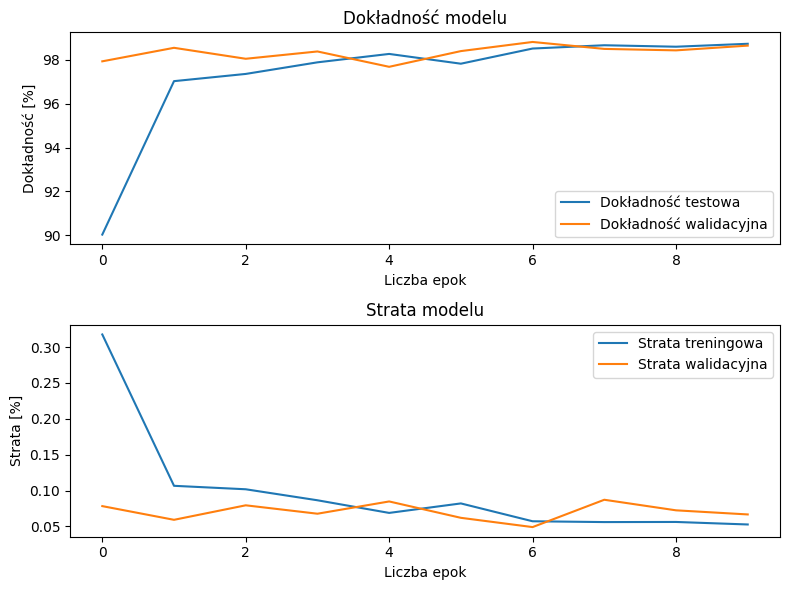


 ----------------------------------------  Testowanie modelu VGG16/1  ---------------------------------------- 


 ----------------------------------------  Macierz pomyłek VGG16/1  ---------------------------------------- 



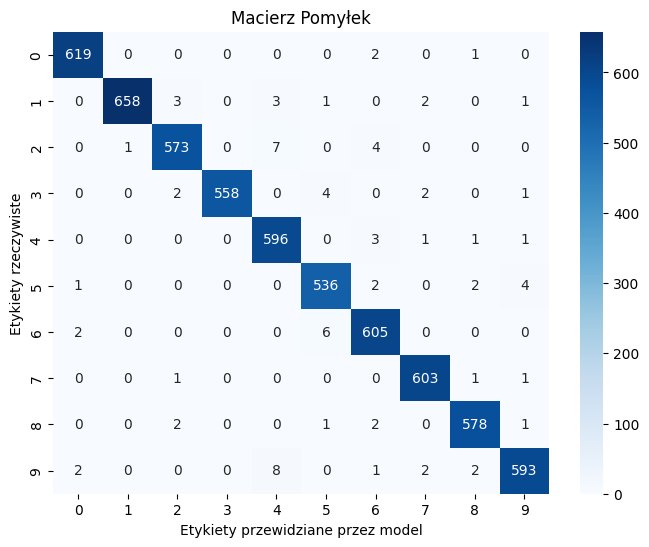


 ----------------------------------------  AUC i ROC VGG16/1  ---------------------------------------- 



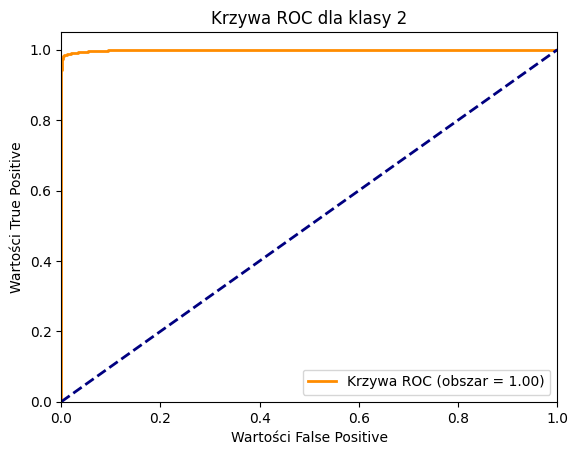

AUC dla klasy 0: 0.004
AUC dla klasy 1: 0.122
AUC dla klasy 2: 0.242
AUC dla klasy 3: 0.346
AUC dla klasy 4: 0.453
AUC dla klasy 5: 0.561
AUC dla klasy 6: 0.663
AUC dla klasy 7: 0.779
AUC dla klasy 8: 0.885
AUC dla klasy 9: 0.988

Average AUC: 0.5043


 ----------------------------------------  Metryki pomiarowe VGG16/9  ---------------------------------------- 

Precision: 0.9864478082197324
Recall: 0.9864394322485692
F1-Score: 0.9864151250486339

 ----------------------------------------   Model AlexNet/2  ---------------------------------------- 



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 ----------------------------------------  Trening modelu AlexNet/2  ---------------------------------------- 

Epoch 1/10 | loss: 0.33% - accuracy: 89.46%, val_loss: 0.09% - val_accuracy: 97.78%
Epoch 2/10 | loss: 0.11% - accuracy: 96.94%, val_loss: 0.07% - val_accuracy: 98.22%
Epoch 3/10 | loss: 0.09% - accuracy: 97.55%, val_loss: 0.06% - val_accuracy: 98.32%
Epoch 4/10 | loss: 0.09% - accuracy: 97.74%, val_loss: 0.07% - val_accuracy: 98.13%
Epoch 5/10 | loss: 0.08% - accuracy: 97.91%, val_loss: 0.06% - val_accuracy: 98.68%
Epoch 6/10 | loss: 0.07% - accuracy: 98.20%, val_loss: 0.07% - val_accuracy: 98.50%
Epoch 7/10 | loss: 0.06% - accuracy: 98.51%, val_loss: 0.06% - val_accuracy: 98.87%
Epoch 8/10 | loss: 0.06% - accuracy: 98.46%, val_loss: 0.08% - val_accuracy: 98.17%
Epoch 9/10 | loss: 0.06% - accuracy: 98.52%, val_loss: 0.05% - val_accuracy: 98.75%
Epoch 10/10 | loss: 0.05% - accuracy: 98.61%, val_loss: 0.06% - val_accuracy: 98.82%
Trening ukończony w: 557.7048628330231 sekund


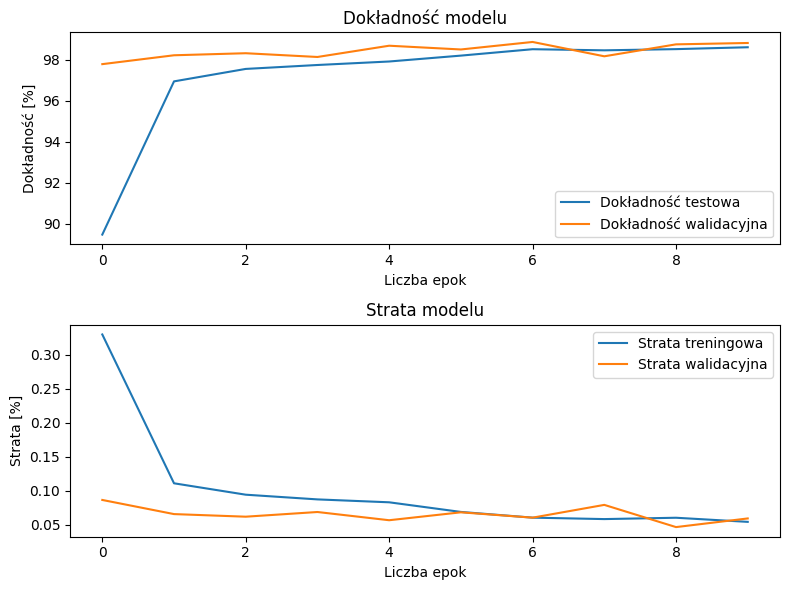


 ----------------------------------------  Testowanie modelu VGG16/2  ---------------------------------------- 


 ----------------------------------------  Macierz pomyłek VGG16/2  ---------------------------------------- 



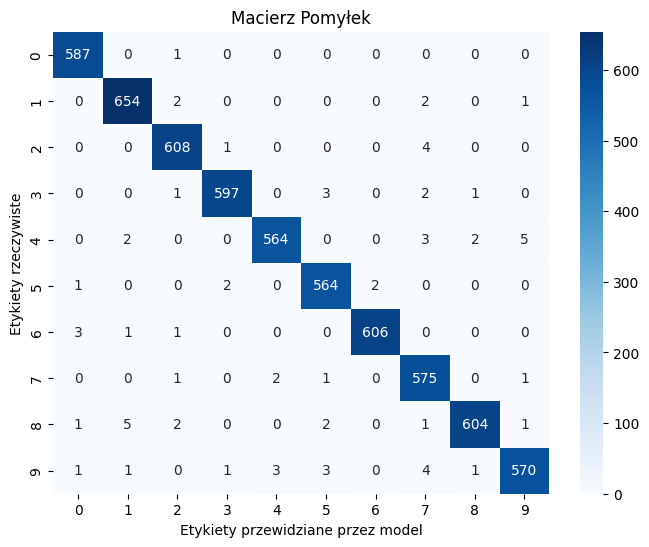


 ----------------------------------------  AUC i ROC VGG16/2  ---------------------------------------- 



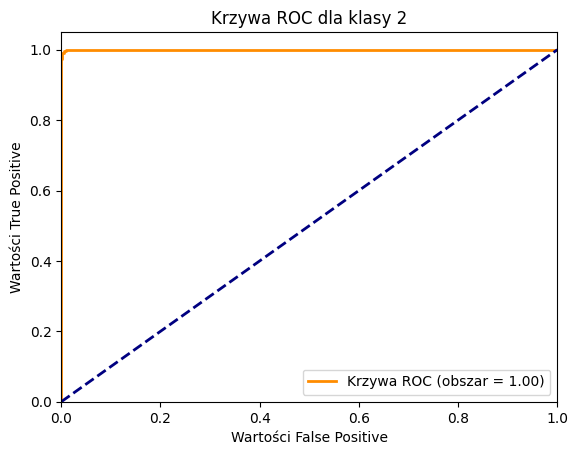

AUC dla klasy 0: 0.001
AUC dla klasy 1: 0.115
AUC dla klasy 2: 0.237
AUC dla klasy 3: 0.35
AUC dla klasy 4: 0.462
AUC dla klasy 5: 0.559
AUC dla klasy 6: 0.666
AUC dla klasy 7: 0.778
AUC dla klasy 8: 0.882
AUC dla klasy 9: 0.989

Average AUC: 0.5040


 ----------------------------------------  Metryki pomiarowe VGG16/9  ---------------------------------------- 

Precision: 0.9881388546447537
Recall: 0.988108825800273
F1-Score: 0.9880989540533855

 ----------------------------------------   Model AlexNet/3  ---------------------------------------- 



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 ----------------------------------------  Trening modelu AlexNet/3  ---------------------------------------- 

Epoch 1/10 | loss: 0.72% - accuracy: 73.99%, val_loss: 0.08% - val_accuracy: 97.60%
Epoch 2/10 | loss: 0.13% - accuracy: 96.49%, val_loss: 0.06% - val_accuracy: 98.13%
Epoch 3/10 | loss: 0.09% - accuracy: 97.36%, val_loss: 0.07% - val_accuracy: 98.43%
Epoch 4/10 | loss: 0.09% - accuracy: 97.68%, val_loss: 0.07% - val_accuracy: 98.27%
Epoch 5/10 | loss: 0.08% - accuracy: 97.79%, val_loss: 0.07% - val_accuracy: 98.10%
Epoch 6/10 | loss: 0.06% - accuracy: 98.30%, val_loss: 0.05% - val_accuracy: 98.68%
Epoch 7/10 | loss: 0.06% - accuracy: 98.37%, val_loss: 0.03% - val_accuracy: 98.95%
Epoch 8/10 | loss: 0.06% - accuracy: 98.38%, val_loss: 0.04% - val_accuracy: 98.95%
Epoch 9/10 | loss: 0.05% - accuracy: 98.61%, val_loss: 0.06% - val_accuracy: 98.50%
Epoch 10/10 | loss: 0.06% - accuracy: 98.50%, val_loss: 0.06% - val_accuracy: 98.75%
Trening ukończony w: 553.8011713027954 sekund


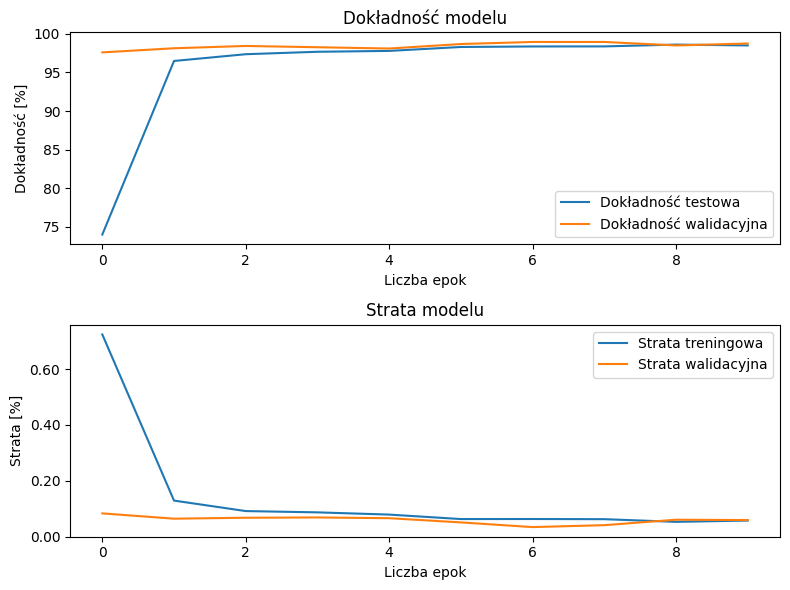


 ----------------------------------------  Testowanie modelu VGG16/3  ---------------------------------------- 


 ----------------------------------------  Macierz pomyłek VGG16/3  ---------------------------------------- 



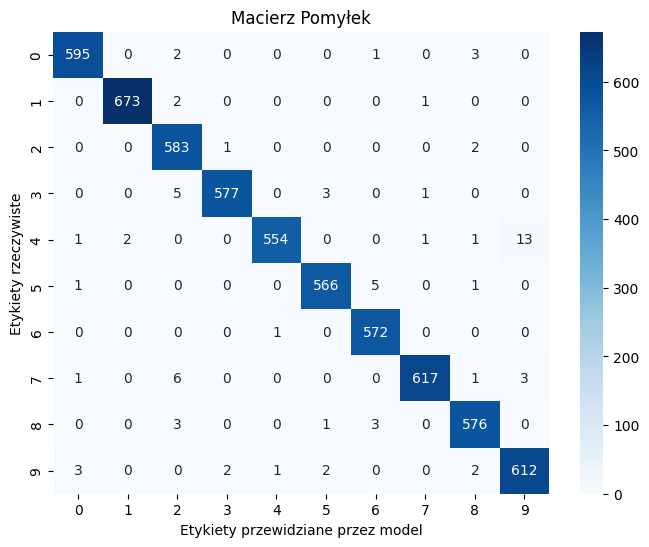


 ----------------------------------------  AUC i ROC VGG16/3  ---------------------------------------- 



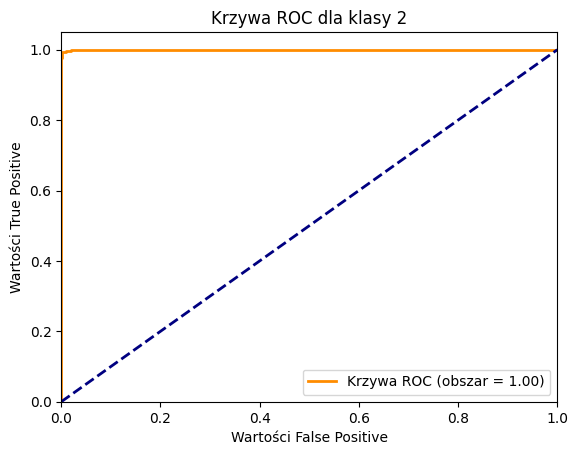

AUC dla klasy 0: 0.006
AUC dla klasy 1: 0.114
AUC dla klasy 2: 0.239
AUC dla klasy 3: 0.347
AUC dla klasy 4: 0.463
AUC dla klasy 5: 0.556
AUC dla klasy 6: 0.661
AUC dla klasy 7: 0.77
AUC dla klasy 8: 0.879
AUC dla klasy 9: 0.99

Average AUC: 0.5025


 ----------------------------------------  Metryki pomiarowe VGG16/9  ---------------------------------------- 

Precision: 0.9874972749529703
Recall: 0.9874070861311439
F1-Score: 0.9874022409730433

 ----------------------------------------   Model AlexNet/4  ---------------------------------------- 



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 ----------------------------------------  Trening modelu AlexNet/4  ---------------------------------------- 

Epoch 1/10 | loss: 1.05% - accuracy: 61.92%, val_loss: 0.12% - val_accuracy: 96.40%
Epoch 2/10 | loss: 0.14% - accuracy: 96.09%, val_loss: 0.09% - val_accuracy: 97.60%
Epoch 3/10 | loss: 0.10% - accuracy: 97.17%, val_loss: 0.05% - val_accuracy: 98.53%
Epoch 4/10 | loss: 0.08% - accuracy: 97.91%, val_loss: 0.05% - val_accuracy: 98.55%
Epoch 5/10 | loss: 0.07% - accuracy: 98.13%, val_loss: 0.06% - val_accuracy: 98.70%
Epoch 6/10 | loss: 0.07% - accuracy: 98.00%, val_loss: 0.05% - val_accuracy: 98.85%
Epoch 7/10 | loss: 0.06% - accuracy: 98.46%, val_loss: 0.06% - val_accuracy: 98.53%
Epoch 8/10 | loss: 0.05% - accuracy: 98.54%, val_loss: 0.06% - val_accuracy: 98.30%
Epoch 9/10 | loss: 0.06% - accuracy: 98.30%, val_loss: 0.05% - val_accuracy: 98.78%
Epoch 10/10 | loss: 0.05% - accuracy: 98.75%, val_loss: 0.04% - val_accuracy: 98.65%
Trening ukończony w: 556.024407863617 sekund



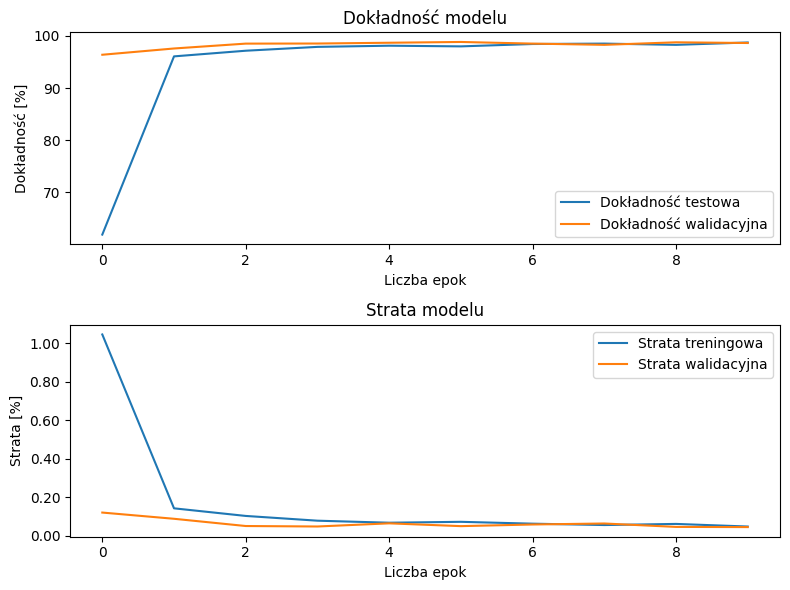


 ----------------------------------------  Testowanie modelu VGG16/4  ---------------------------------------- 


 ----------------------------------------  Macierz pomyłek VGG16/4  ---------------------------------------- 



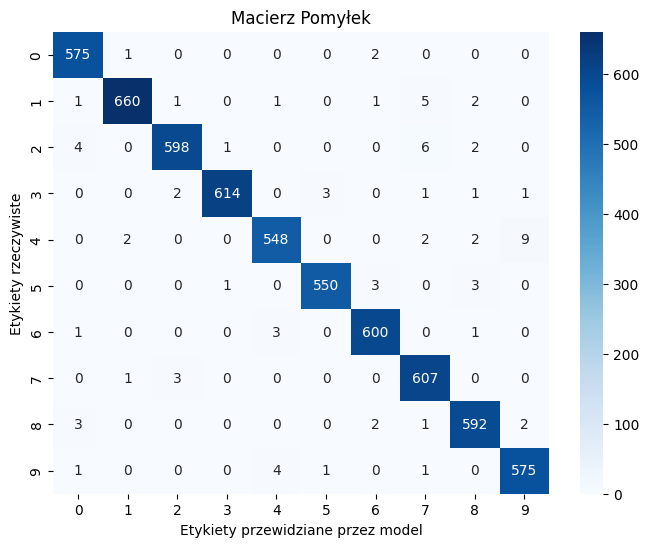


 ----------------------------------------  AUC i ROC VGG16/4  ---------------------------------------- 



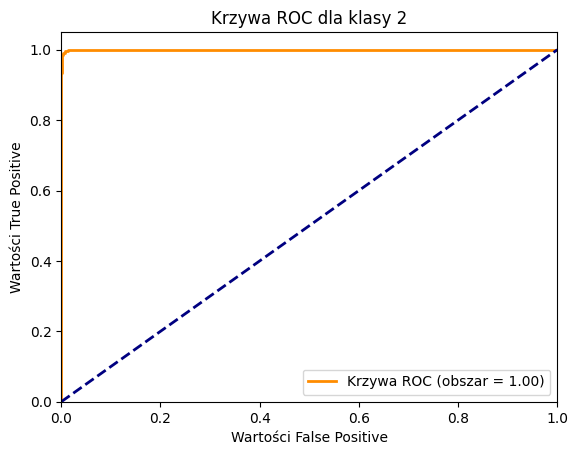

AUC dla klasy 0: 0.003
AUC dla klasy 1: 0.118
AUC dla klasy 2: 0.237
AUC dla klasy 3: 0.347
AUC dla klasy 4: 0.464
AUC dla klasy 5: 0.557
AUC dla klasy 6: 0.662
AUC dla klasy 7: 0.774
AUC dla klasy 8: 0.886
AUC dla klasy 9: 0.993

Average AUC: 0.5042


 ----------------------------------------  Metryki pomiarowe VGG16/9  ---------------------------------------- 

Precision: 0.9864567522028664
Recall: 0.986489567251325
F1-Score: 0.9864443854224101


In [80]:
from collections import defaultdict
from torch.utils.data import DataLoader, Subset

SIZE, EPOCHS = 30000, 15

for i in range(0, 5):

    print('\n', '-'*40, f'{Fore.RED}  Model AlexNet/{i} {Fore.BLACK}', '-'*40, '\n')

    # Ustawienie ziarna dla reprodukowalności
    set_seed(seeds[i])

    # Podział danych w stosunku 80/20
    indices = torch.randperm(len(combined_data))[:SIZE]
    combined_data_sliced = Subset(combined_data, indices)
    train_dataset, validation_dataset = split_dataset(combined_data_sliced)

    # Utworzenie Data Loaders dla zestawu treningowego i testowego
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

    # Utworzenie modelu AlexNet
    model, criterion, optimizer = create_alexnet_model()

    # Trening model
    print('\n', '-'*40, f'{Fore.GREEN} Trening modelu AlexNet/{i} {Fore.BLACK}', '-'*40, '\n')

    start_time = time.time()
    output_dict = train_alexnet_on_mnist(model, criterion, optimizer, train_loader, val_loader)
    end_time = time.time()

    training_time = end_time - start_time
    print(f'Trening ukończony w: {training_time} sekund')

    print('\n', '-'*40, f'{Fore.GREEN}Dokładność i strata modelu AlexNet/{i} na wykresach {Fore.BLACK}', '-'*40, '\n')

    from collections import defaultdict

    metrics = defaultdict(list)
    for val in output_dict.values():
      metrics['accuracy'].append(val[0])
      metrics['val_accuracy'].append(val[1])
      metrics['loss'].append(val[2])
      metrics['val_loss'].append(val[3])

    plot_accuracy_and_loss(metrics)

    print('\n', '-'*40, f'{Fore.GREEN} Testowanie modelu VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    predictions, true_labels = validate_model(model, val_loader)

    print('\n', '-'*40, f'{Fore.GREEN} Macierz pomyłek VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    class_names = [str(i) for i in range(10)]
    plot_confusion_matrix(true_labels, predictions, class_names)

    print('\n', '-'*40, f'{Fore.GREEN} AUC i ROC VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    plot_ROC(model, val_loader)

    aucs, average_auc = compute_auc_per_class(true_labels, predictions)
    for x, a in enumerate(aucs):
      print(f'AUC dla klasy {x}: {round(a, 3)}')

    print(f"\nAverage AUC: {average_auc:.4f}\n")

    print('\n', '-'*40, f'{Fore.GREEN} Metryki pomiarowe VGG16/{i} {Fore.BLACK}', '-'*40, '\n')

    num_classes = 10
    precision, recall, f1score = compute_precision_recall_f1score(true_labels, predictions, num_classes)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1score)

    del model, train_loader, val_loader, training_time, output_dict, metrics, predictions, true_labels, precision, recall, f1score